In [1]:
import pathlib

import pandas as pd
import sys
sys.path.append('src')
from dataset import Dataset, Entry

## Loading and preparing data

In [2]:
df = Dataset(csv_file_path=pathlib.Path('other', 'daylio-data', 'daylio_export_2025_03_11.csv'), remove=True)

Dataset(76 entries; last [2 hours 24 minutes 56 seconds ago]; mood: 3.934 ± 0.943)


In [3]:
ACTIVITIES = list(df.activities().keys())

In [4]:
def entry_to_list(entry: Entry, with_mood: bool = True) -> list:
    return [act in entry.activities for act in ACTIVITIES] + ([entry.mood] if with_mood else [])

In [5]:
from typing import Iterable
def pd_dataframe_from_entries(entries: Iterable[Entry]) -> pd.DataFrame:
    return pd.DataFrame([entry_to_list(entry) for entry in entries], columns=ACTIVITIES + ['mood'])

In [6]:
new_df = pd_dataframe_from_entries(df.entries)

In [7]:
new_df

,work day,cleaning,eat healthy,make list,No fap,start late (10am or later),time together,appreciate,good sleep,go outside,...,hiking,sick,Audiobook/Podcast,give gift,Cinema,start early (between 9-10am),meditate,fitness,Yoga,mood
0,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,5.0
1,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,4.0
2,True,False,False,False,True,False,True,False,True,True,...,False,False,False,False,False,False,False,False,False,3.0
3,False,True,True,False,True,False,True,False,True,True,...,False,False,False,False,False,False,False,False,False,5.0
4,False,True,False,False,True,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2.0
72,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1.0
73,False,False,True,False,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,5.0
74,False,False,True,False,False,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,5.0


In [8]:
# standardize the mood column
mean = new_df['mood'].mean()
std = new_df['mood'].std()
new_df['mood'] = (new_df['mood'] - mean) / std

## Learning

In [9]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [10]:
df_input = new_df[ACTIVITIES]
df_labels = new_df['mood']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_input, df_labels, test_size=0.2)

In [12]:
model = MLPRegressor(
    hidden_layer_sizes=(100,), 
    activation='relu', 
    max_iter=2000,
    solver='adam', 
    verbose=True
)
model.fit(X_train, y_train)

Iteration 1, loss = 0.64908874
Iteration 2, loss = 0.62351332
Iteration 3, loss = 0.59973508
Iteration 4, loss = 0.57771704
Iteration 5, loss = 0.55716083
Iteration 6, loss = 0.53814567
Iteration 7, loss = 0.52059983
Iteration 8, loss = 0.50433961
Iteration 9, loss = 0.48920648
Iteration 10, loss = 0.47510458
Iteration 11, loss = 0.46182830
Iteration 12, loss = 0.44934992
Iteration 13, loss = 0.43751749
Iteration 14, loss = 0.42626671
Iteration 15, loss = 0.41556996
Iteration 16, loss = 0.40536036
Iteration 17, loss = 0.39558878
Iteration 18, loss = 0.38622575
Iteration 19, loss = 0.37723982
Iteration 20, loss = 0.36858976
Iteration 21, loss = 0.36028889
Iteration 22, loss = 0.35233924
Iteration 23, loss = 0.34471830
Iteration 24, loss = 0.33739136
Iteration 25, loss = 0.33039923
Iteration 26, loss = 0.32370001
Iteration 27, loss = 0.31728405
Iteration 28, loss = 0.31111534
Iteration 29, loss = 0.30522205
Iteration 30, loss = 0.29953749
Iteration 31, loss = 0.29402901
Iteration 32, los

MLPRegressor(max_iter=2000, verbose=True)

In [13]:
model.score(X_test, y_test)

-0.35460284801764663

## Testing

### On the test dataset

In [14]:
test_inputs = X_test
test_labels = list(y_test * std + mean)

In [19]:
len(test_inputs)

16

In [15]:
predictions = model.predict(test_inputs) * std + mean

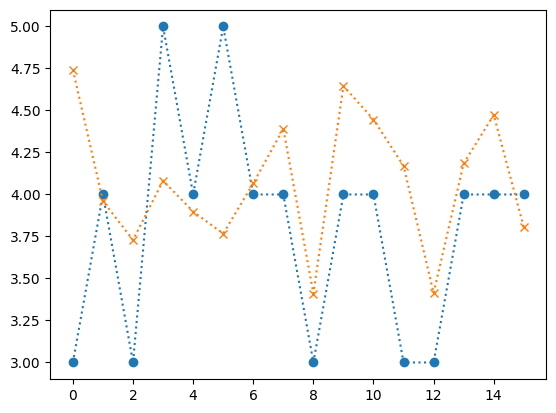

In [16]:
import matplotlib.pyplot as plt
plt.plot(test_labels, 'o:')
plt.plot(predictions, 'x:')

### On new entries

In [17]:
def preduct_mood(entry: Entry, model) -> float:
    df_one_entry = pd_dataframe_from_entries([entry]).drop(columns=['mood'])
    return model.predict(df_one_entry)[0] * std + mean

In [18]:
ent = df.entries[48]
print(f'mood_predicted={preduct_mood(ent, model)}; mood_actual={ent.mood}')

mood_predicted=2.9991172741672614; mood_actual=3.0
